In [1]:
!pip install tensorflow pandas matplotlib numpy scikit-learn

### Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

### Membaca File CSV dan Menampilkan Data Awal

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# google drive
# df_pidana_umum = pd.read_csv("drive/MyDrive/Colab Notebooks/Dataset_PeduliPasal/dataset_pidana_umum.csv")

# local computer
df_pidana_umum = pd.read_csv("../data/dataset_csv/dataset_pidana_umum.csv")

In [7]:
df_pidana_umum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10729 entries, 0 to 10728
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   amar                10729 non-null  object
 1   amar_lainnya        10729 non-null  object
 2   id                  10729 non-null  object
 3   klasifikasi         10729 non-null  object
 4   lama_hukuman        10729 non-null  int64 
 5   lembaga_peradilan   10729 non-null  object
 6   provinsi            10729 non-null  object
 7   status              10729 non-null  object
 8   sub_klasifikasi     10729 non-null  object
 9   url                 10729 non-null  object
 10  kepala_putusan      10727 non-null  object
 11  identitas           9481 non-null   object
 12  riwayat_penahanan   8830 non-null   object
 13  riwayat_perkara     10630 non-null  object
 14  riwayat_tuntutan    10228 non-null  object
 15  riwayat_dakwaan     10577 non-null  object
 16  fakta               10

In [8]:
# Select relevant features and target
features = ['riwayat_perkara', 'riwayat_tuntutan', 'riwayat_dakwaan', 'fakta']
target = 'sub_klasifikasi'  # Target column for "pasal yang berlaku"

# Drop rows with missing target or all features empty
dataset_cleaned = df_pidana_umum.dropna(subset=features + [target])

# Combine textual features into a single column
dataset_cleaned['combined_text'] = dataset_cleaned[features].fillna('').agg(' '.join, axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15644\12682325.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['combined_text'] = dataset_cleaned[features].fillna('').agg(' '.join, axis=1)


In [10]:
# Prepare input (X) and output (y)
X = dataset_cleaned['combined_text']
y = dataset_cleaned[target]

# Encode the target (sub_classification) into integer classes
sub_classification = y.unique()
class_mapping = {label: idx for idx, label in enumerate(sub_classification)}
y_encoded = y.map(class_mapping)

In [15]:
df_sub_classification = pd.DataFrame(sub_classification)

df_sub_classification.to_csv("../data/dataset_csv/data_classfication.csv", index=False)

In [11]:
# Tokenization and padding
max_words = 20000  # Increase the vocabulary size
max_len = 300      # Increase the sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Convert the target to categorical (one-hot encoding)
y_categorical = to_categorical(y_encoded)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [ ]:
# Build the Sequential model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    BatchNormalization(),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    BatchNormalization(),

    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(sub_classification), activation='softmax')  # Output layer for multi-class classification
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 91s 661ms/step - accuracy: 0.1449 - loss: 2.8115 - val_accuracy: 0.1254 - val_loss: 2.7020
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 138s 630ms/step - accuracy: 0.3892 - loss: 1.9714 - val_accuracy: 0.1228 - val_loss: 3.0891
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 81s 623ms/step - accuracy: 0.4786 - loss: 1.6133 - val_accuracy: 0.1477 - val_loss: 2.8595
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 77s 619ms/step - accuracy: 0.5360 - loss: 1.4234 - val_accuracy: 0.3919 - val_loss: 2.1850
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 86s 648ms/step - accuracy: 0.5672 - loss: 1.3339 - val_accuracy: 0.5310 - val_loss: 1.3958
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 625ms/step - accuracy: 0.5890 - loss: 1.2065 - val_accuracy: 0.5695 - val_loss: 1.3086
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 636ms/step - accuracy: 0.6422 - loss: 1.0228 - val_accuracy: 0.5980 - val_loss: 1.2872
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 650ms/step - accuracy: 0.6935 - loss: 

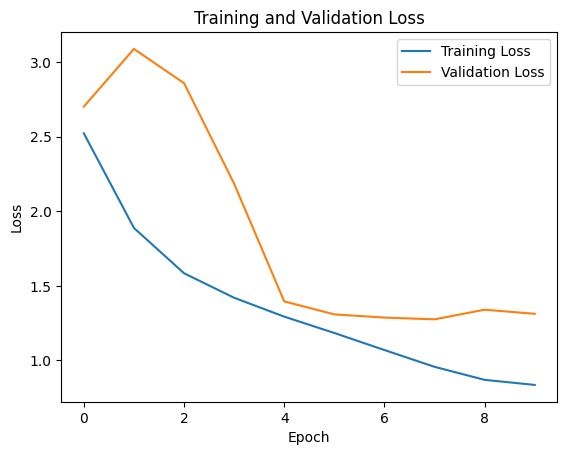

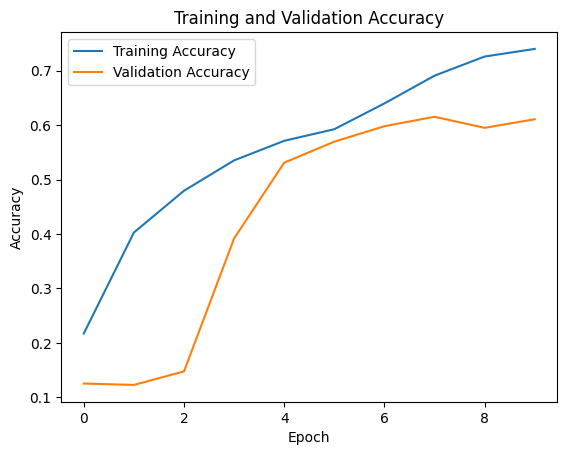

In [20]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2%}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6144 - loss: 1.2827
Test Accuracy: 61.07%


In [ ]:
# Predict on new cases
def predict_pasal(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(input_padded)
    predicted_class = sub_classification[prediction.argmax()]
    return predicted_class

In [23]:
# Example usage
sample_case = "Kasus pencurian"
predicted_pasal = predict_pasal(sample_case)
print(f"Predicted Pasal: {predicted_pasal}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Predicted Pasal: penipuan


Run this if you want to save the model in the google drive

In [27]:
with open("drive/MyDrive/Colab Notebooks/Models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

model.save('drive/MyDrive/Colab Notebooks/Models/model_pidana_umum.h5')

Run this if you want to save the model in the local computer

In [ ]:
# with open("../models/tokenizer.pkl", "wb") as f:
#     pickle.dump(tokenizer, f)

# model.save('../models/model_pidana_umum.h5')